**Candidate Name**: Sneha Santha Prabakar


**Week 5 Assignment**: Transformer-based Sentiment Classification

In [61]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Section 1: Import libraries and dataset

In [62]:
#!pip install datasets
# !pip install tensorflow
# !pip install keras

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
dataset = load_dataset("imdb")
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 25000
Test size: 25000


In [ ]:
train_df.head()

We are using the Hugging Face dataset, IMDB, for movie reviews.

There are 25,000 records for training and 25,000 for testing.

Each review is labeled as 0 (negative) or 1 (positive).

# Section 2: EDA visualization

We first check if the dataset is balanced. A balanced dataset (equal number of positive/negative reviews) is important for fair model training.

In [ ]:
# Understand Class Distribution
sns.countplot(x='label', data=train_df)

We also check how long the reviews are — so we can decide how long our input sequences should be.

Transformer models require fixed-length inputs.

In [ ]:
# Review length
train_df['text'].apply(lambda x: len(x.split()))

# Section 3: Handle missing values and outliers

Missing values: We remove records with value = NA

Outliers: We filter out reviews that are longer than 1000 words, to remove extreme outliers.

Reviews with less than or equal to 1000 words are kept

In [65]:
# Handle Missing Values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Remove Outliers (very long reviews)
train_df["length"] = train_df["text"].apply(lambda x: len(x.split()))
train_df = train_df[train_df["length"] <= 1000].drop(columns="length")

# Section 4: Tokenization and Padding

Tokenization:

- We create a vocabulary of the most frequent 15,000 words.

- Unknown words will be replaced by `OOV` ("out-of-vocabulary").

Padding:

- Each review becomes a sequence of integers (each word → number).

- We then pad all sequences to the same length (256 words), so they can be processed in batches.

In [66]:
# Tokenization
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["text"])

X_train = tokenizer.texts_to_sequences(train_df["text"])
X_test = tokenizer.texts_to_sequences(test_df["text"])

# Padding
X_train = pad_sequences(X_train, maxlen=256, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=256, padding="post", truncating="post")

y_train = train_df["label"].values
y_test = test_df["label"].values

# Section 5: Data splitting

We will split the training data with stratification to create a training and validation split (80/20), to help us monitor generalization during training.

In [67]:
# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)


# Section 6: Basic Transformer Model

We will build a basic regularized transformer model with:

- Embedding layer

- Custom TransformerEncoder block with multi-head attention and FFN

- GlobalAveragePooling1D

- Output Dense(1, activation='sigmoid')

We will also use dropout and L2 regularization to prevent overfitting.

In [68]:
# TransformerEncoder Layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.3):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
            layers.Dense(embed_dim, kernel_regularizer=regularizers.l2(1e-4))
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [69]:
# Build Regularized Basic Transformer Model
def basic_transformer_model():
    inputs = keras.Input(shape=(256,))
    x = layers.Embedding(input_dim=15000, output_dim=64)(inputs)
    x = TransformerEncoder(embed_dim=64, num_heads=2, ff_dim=32, dropout=0.3)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(1e-4))(x)
    return keras.Model(inputs=inputs, outputs=outputs)

model = basic_transformer_model()
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 256, 64)        │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_8           │ (None, 256, 64)        │        37,664 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 997,729 (3.81 MB)

 Trainable params: 997,729 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

We will now compile the model with 'binary_crossentropy' loss and adam optimizer (with low learning rate), and train it for 5 epochs with a batch size of 64.

In [70]:
# Compile Model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR to slow overfitting
    metrics=["accuracy"]
)

# EarlyStopping Callback
# early_stop = EarlyStopping(
#     monitor="val_loss",
#     patience=2,
#     restore_best_weights=True
# )

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64
    # callbacks=[early_stop]
)

Epoch 1/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 202s 636ms/step - accuracy: 0.5700 - loss: 0.6923 - val_accuracy: 0.7782 - val_loss: 0.5616
Epoch 2/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 198s 636ms/step - accuracy: 0.7806 - loss: 0.5142 - val_accuracy: 0.8257 - val_loss: 0.3847
Epoch 3/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 196s 629ms/step - accuracy: 0.8746 - loss: 0.3092 - val_accuracy: 0.8824 - val_loss: 0.2920
Epoch 4/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 196s 629ms/step - accuracy: 0.9107 - loss: 0.2361 - val_accuracy: 0.8864 - val_loss: 0.2894
Epoch 5/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 197s 630ms/step - accuracy: 0.9311 - loss: 0.1923 - val_accuracy: 0.8792 - val_loss: 0.3237


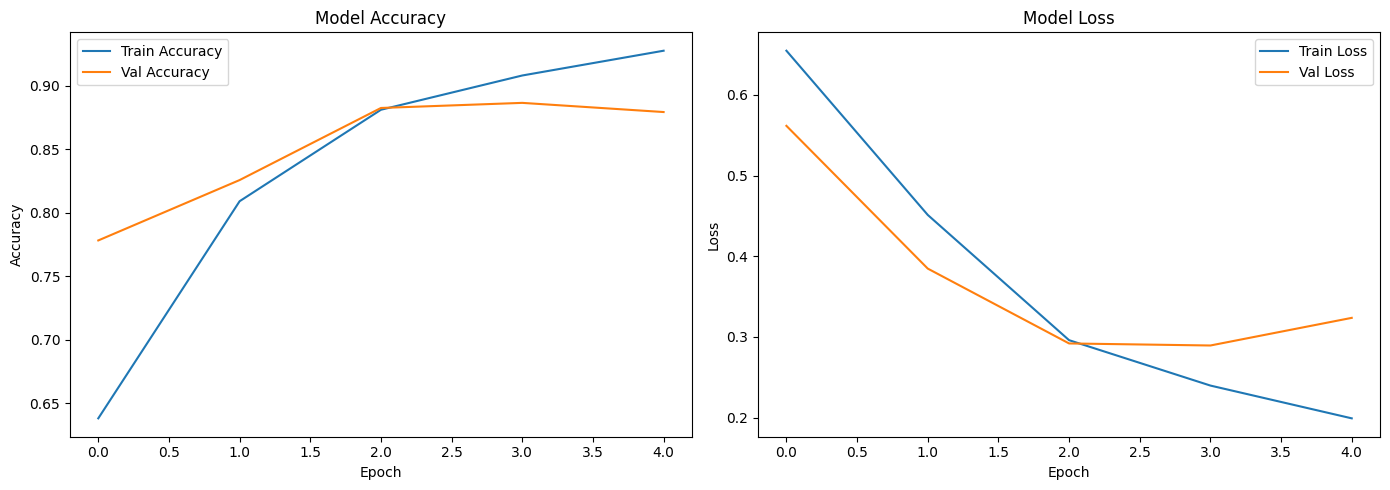

In [71]:
# Plot Results
def plot_history(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


**Accuracy plot**:

- Epoch 0–1: Rapid improvement in both training and validation accuracy. Model is learning useful patterns from the data.
- Epoch 2: Training and validation accuracy both reach ~88%, indicating the model is generalizing well.
- Epochs 3–4: Training accuracy continues to increase (above 91%). Validation accuracy plateaus and then slightly declines (~88% → ~87.5%).

This shows that early training phases show excellent convergence.

The best generalisation is achieved with epoch = 2 where both training and validation accuracy intersect, around 88%.

Around Epoch 3+, a generalization gap emerges, as validation accuracy no longer improves and may be slightly degraded, and the model starts to overfit.

**Loss plot**:

- Training loss steadily decreases, which is a sign of effective learning.
- Validation loss:

    - Decreases initially (Epochs 0–2).

    - Stalls at Epoch 2.

    - Increases slightly after Epoch 3.

**Final comments**

Epoch 2 appears to be the optimal stopping point — both accuracy and loss are at their best.

From Epoch 3 onward:
Training loss keeps dropping, but validation loss rises — a classic sign of overfitting.

In [72]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict probabilities
y_pred_probs = model.predict(X_val).flatten()

# Convert to class labels (0 or 1)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Classification Report
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_pred_labels, digits=4))

# AUC-ROC
auc = roc_auc_score(y_val, y_pred_probs)
print(f"AUC-ROC: {auc:.4f}")

156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9128    0.8385    0.8741      2496
           1     0.8506    0.9198    0.8838      2494

    accuracy                         0.8792      4990
   macro avg     0.8817    0.8792    0.8790      4990
weighted avg     0.8817    0.8792    0.8790      4990

AUC-ROC: 0.9528


We can see that the model has strong generalization, especially in identifying positive sentiment (Recall = 0.92).

It's slightly more cautious when predicting negative sentiment, prioritizing precision over recall.

With AUC-ROC = 0.9528, the basic model distinguishes classes very well — better than accuracy alone shows.

Both classes are above 85% F1-score, which is solid.

# Section 7: Advanced Transformer Model

In [73]:
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(sequence_length, d_model)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


In [74]:
def advanced_transformer_model():
    inputs = keras.Input(shape=(256,))
    x = layers.Embedding(input_dim=15000, output_dim=64)(inputs)
    x = PositionalEncoding(sequence_length=256, d_model=64)(x)

    # Multi-head attention
    attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    attn_output = layers.Dropout(0.3)(attn_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

    # Feedforward + Dropout
    ffn = keras.Sequential([
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(64, kernel_regularizer=regularizers.l2(1e-4))
    ])
    ffn_output = ffn(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))(x)
    return keras.Model(inputs=inputs, outputs=outputs)


In [75]:
model_advanced = advanced_transformer_model()
model_advanced.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history_advanced = model_advanced.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.4923 - loss: 0.7613 - val_accuracy: 0.5102 - val_loss: 0.7024
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.5447 - loss: 0.7052 - val_accuracy: 0.7144 - val_loss: 0.6692
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.6634 - loss: 0.6530 - val_accuracy: 0.8012 - val_loss: 0.5023
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.8046 - loss: 0.4678 - val_accuracy: 0.8459 - val_loss: 0.3806
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.8599 - loss: 0.3520 - val_accuracy: 0.8615 - val_loss: 0.3485
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.8846 - loss: 0.2959 - val_accuracy: 0.8709 - val_loss: 0.3334
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.9046 - loss: 0.2625 - val_accuracy: 0.8754 - val_loss: 0.3326
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.9181 - loss: 0.2336 - val_accu

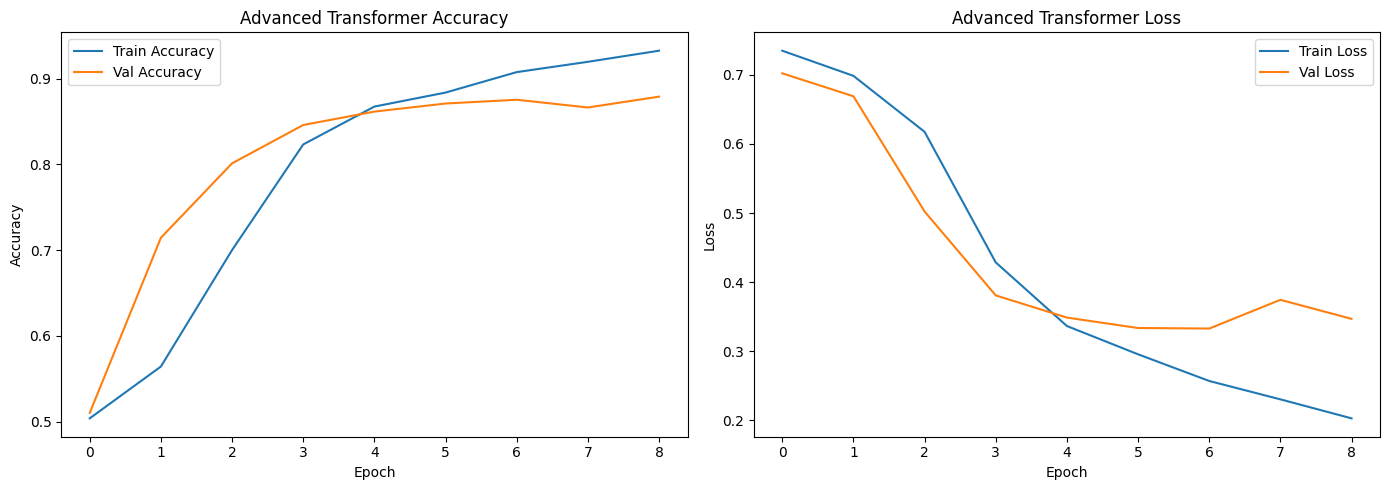

In [76]:
def plot_history(history, title_prefix="Advanced Transformer"):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_advanced)


**Accuracy plot**:

- Epochs 0–4:

  - Steady rise in both training and validation accuracy.

  - Model learns rapidly and generalizes well up to this point.

- Epochs 5–6:

  - Training accuracy continues increasing (~91% → ~93%).

  - Validation accuracy plateaus around 88%–89%.

- Epoch 7:

  - Minor drop in validation accuracy while training accuracy still increases.

We can see that there is strong generalization in early stages, and after epoch 5, there is minor overfitting as the validation accuracy no longer improves even as training accuracy increases.

**Loss plot**:

- Epochs 0–4:

  - Both training and validation loss drop rapidly — great learning phase.

- Epochs 5–6:

  - Training loss keeps decreasing.

  - Validation loss begins to flatten, then slightly increases at Epoch 7.

- Epoch 8:

  - Small recovery in validation loss.

**Final comments**

The best performing epoch is likely Epoch 5 or 6.

The advanced model generalizes better than the basic model (higher and more stable validation accuracy/loss).

This validates the improvements from:

- Positional encoding

- Multi-head attention

- Proper regularization

In [2]:
# Predict probabilities
y_pred_probs = model_advanced.predict(X_val).flatten()

# Convert to class labels (0 or 1)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Classification Report
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_pred_labels, digits=4))

# AUC-ROC
auc = roc_auc_score(y_val, y_pred_probs)
print(f"AUC-ROC: {auc:.4f}")

NameError: name 'model_advanced' is not defined

# Section 8: Compare the two models

156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step


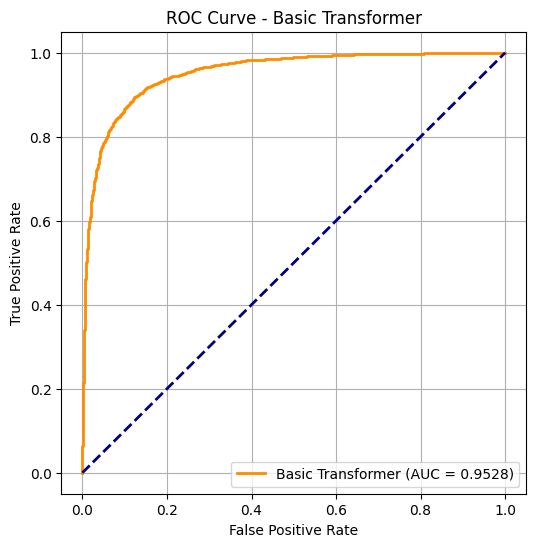

156/156 ━━━━━━━━━━━━━━━━━━━━ 28s 179ms/step


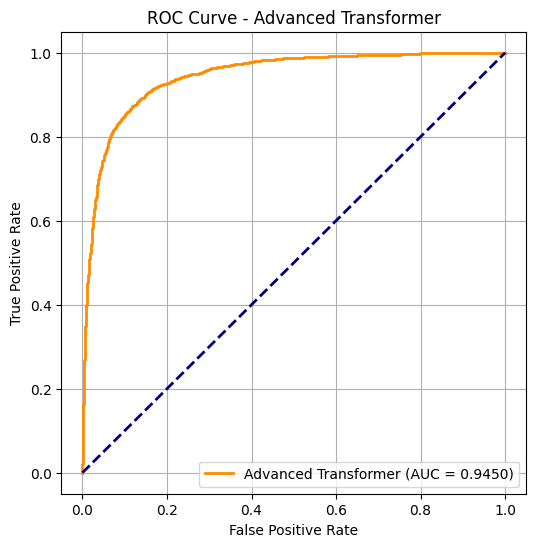

In [77]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_pred_probs, title="ROC Curve", label="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{label} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
# BASIC model predictions
y_pred_probs_basic = model.predict(X_val).flatten()

# Plot ROC for Basic Model
plot_roc_curve(y_val, y_pred_probs_basic, title="ROC Curve - Basic Transformer", label="Basic Transformer")

# ADVANCED model predictions
y_pred_probs_advanced = model_advanced.predict(X_val).flatten()

# Plot ROC for Advanced Model
plot_roc_curve(y_val, y_pred_probs_advanced, title="ROC Curve - Advanced Transformer", label="Advanced Transformer")


**Basic Transformer ROC**

AUC-ROC = 0.9528

Curve rises steeply toward the top-left.

High true positive rate with low false positives.

Strong overall separation between classes.

Slightly sharper curve than the advanced model, meaning it’s more confident in its predictions.

**Advanced Transformer ROC**

AUC-ROC = 0.9450

Still an excellent curve — well above random baseline.

Smooth and strong classification boundary.

Slightly lower AUC than the basic model — possibly due to increased regularization and slightly more conservative decision boundary.

**Comparison**

Both models are excellent at binary classification on IMDB reviews.

The basic transformer performs slightly better on AUC but risks overfitting. The advanced transformer, while having a slightly lower AUC, is more stable and consistent across epochs. For deployment, the advanced model is the safer choice.